# **PFL on MNIST**

## Imports

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset # Added Subset
from torchvision import datasets, transforms # For MNIST

# Ensure ALL sklearn metrics you use are imported here:
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, f1_score, classification_report,
    precision_score, recall_score, balanced_accuracy_score,
    accuracy_score, average_precision_score # Added average_precision_score for PR-AUC
)
import warnings
import copy
import os # For creating data directory

# Suppress warnings (optional)
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


## **MNIST Specific Parameters**

### General MNIST

In [87]:
NUM_CLASSES_MNIST = 10
MNIST_DATA_PATH = "./mnist_data/"
if not os.path.exists(MNIST_DATA_PATH):
    os.makedirs(MNIST_DATA_PATH)

## **For Per-FedAvg and MOCHA (10-class)**

In [88]:
CLIENT_DIGITS_MAP_10_CLASS = {
    0: list(range(5)),   
    1: list(range(5, 10))  
}

## **Data preparation**

In [89]:
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Define client digit splits (non-overlapping!)
CLIENT_DIGITS_MAP_10_CLASS = {
    0: [0, 1, 2, 3, 4],
    1: [5, 6, 7, 8, 9],
}

# Basic transforms: normalize + to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test
mnist_train = datasets.MNIST(root=MNIST_DATA_PATH, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root=MNIST_DATA_PATH, train=False, download=True, transform=transform)

# Create digit index mappings per client
train_idxs = {
    cid: [i for i, (_, lbl) in enumerate(mnist_train) if lbl in CLIENT_DIGITS_MAP_10_CLASS[cid]]
    for cid in [0, 1]
}
test_idxs = {
    cid: [i for i, (_, lbl) in enumerate(mnist_test) if lbl in CLIENT_DIGITS_MAP_10_CLASS[cid]]
    for cid in [0, 1]
}

# Parameters
batch_size_train = 64
batch_size_test = 128
support_fraction = 0.5

# Dicts to hold client loaders
client_support_loaders_10way = {}
client_query_loaders_10way = {}
client_test_loaders_10way = {}

for cid in [0, 1]:
    # Full subset per client
    subset_train = Subset(mnist_train, train_idxs[cid])
    subset_test = Subset(mnist_test, test_idxs[cid])

    # === Split subset_train into support and query ===
    total = len(subset_train)
    support_len = int(support_fraction * total)
    query_len = total - support_len
    support_set, query_set = random_split(subset_train, [support_len, query_len])

    # Loaders
    client_support_loaders_10way[cid] = DataLoader(support_set, batch_size=batch_size_train, shuffle=True, num_workers=0)
    client_query_loaders_10way[cid] = DataLoader(query_set, batch_size=batch_size_train, shuffle=True, num_workers=0)
    client_test_loaders_10way[cid] = DataLoader(subset_test, batch_size=batch_size_test, shuffle=False, num_workers=0)

    # Optional: sanity check label coverage
    support_labels = [mnist_train[i][1] for i in support_set.indices]
    query_labels = [mnist_train[i][1] for i in query_set.indices]
    test_labels = [mnist_test[i][1] for i in test_idxs[cid]]
    print(f"\nClient {cid}:")
    print(f"  Support label classes: {sorted(set(support_labels))}")
    print(f"  Query label classes:   {sorted(set(query_labels))}")
    print(f"  Test label classes:    {sorted(set(test_labels))}")


Client 0:
  Support label classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Query label classes:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Test label classes:    [0, 1, 2, 3, 4]

Client 1:
  Support label classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Query label classes:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  Test label classes:    [5, 6, 7, 8, 9]


In [90]:
len(set(CLIENT_DIGITS_MAP_10_CLASS[0]) & set(CLIENT_DIGITS_MAP_10_CLASS[1])) == 0

True

## **MNIST CNN model architecture**

In [91]:
class Mnist10WayMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim1=128, hidden_dim2=64, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        # Output layer now has num_classes = 10
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        # x is (batch_size, 784)
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x) # (batch_size, 10)
        return x

### CNN backbone and head (For MOCHA)

In [92]:
class CNN_Backbone(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)   

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)           
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)   

        self.output_dim = 64 * 7 * 7

    def forward(self, x):
        # x: (batch_size, 1, 28, 28)
        x = self.pool1(self.relu1(self.conv1(x)))  # (batch_size, 32, 14, 14)
        x = self.pool2(self.relu2(self.conv2(x)))  # (batch_size, 64, 7, 7)
        x = x.view(-1, self.output_dim)            # (batch_size, 3136)
        return x

In [ ]:
class CNN_Head(nn.Module):
    def __init__(self, input_dim=64*7*7, head_fc_hidden=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, head_fc_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Final layer now outputs num_classes = 10
        self.fc2 = nn.Linear(head_fc_hidden, num_classes)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))  
        x = self.fc2(x)                           
        return x

In [ ]:
CNN_HEAD_FC_HIDDEN_HP = 128  

class Mnist10WayCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CNN_Backbone(input_channels=1)
        self.head     = CNN_Head(input_dim=self.backbone.output_dim,
                                 head_fc_hidden=CNN_HEAD_FC_HIDDEN_HP,
                                 num_classes=NUM_CLASSES_MNIST)

    def forward(self, x):
        # x: (batch_size, 1, 28, 28)
        features = self.backbone(x)  
        logits   = self.head(features)  #
        return logits

In [ ]:
from torch.utils.data import random_split

client_inner_loaders_10way = {}
client_meta_loaders_10way  = {}

meta_fraction = 0.2 # 20% of client train data used for meta-loss

for cid in [0, 1]:
    full_dataset = Subset(mnist_train, train_idxs[cid])
    total_len = len(full_dataset)
    meta_len  = int(meta_fraction * total_len)
    inner_len = total_len - meta_len

    inner_ds, meta_ds = random_split(full_dataset, [inner_len, meta_len])

    client_inner_loaders_10way[cid] = DataLoader(
        inner_ds, batch_size=batch_size_train, shuffle=True, num_workers=0
    )
    client_meta_loaders_10way[cid] = DataLoader(
        meta_ds, batch_size=batch_size_train, shuffle=True, num_workers=0
    )

    print(f"Client {cid}: Inner batches = {len(client_inner_loaders_10way[cid])}, "
          f"Meta batches = {len(client_meta_loaders_10way[cid])}")

Client 0: Inner batches = 383, Meta batches = 96
Client 1: Inner batches = 368, Meta batches = 92


## **PFL Helper Functions**

### Generic Helpers

In [ ]:
def get_model_parameters(model):
    return {name: param.data.clone() for name, param in model.named_parameters()}

def set_model_parameters(model, params):
    model.load_state_dict(params, strict=False)
    return get_model_parameters(model)

def average_states(state_dicts, weights):
    if not state_dicts: return {}
    avg_state_dict = {}
    total_weight = sum(weights)
    if total_weight == 0:
        return state_dicts[0] if state_dicts else {}

    for key in state_dicts[0].keys():
        if state_dicts[0][key] is None:
            continue
        
        # For Per-FedAvg, shapes must matc, for MOCHA backbone, they will (added for bug fix)
        valid_to_average = all(
            key in sd and sd[key] is not None and sd[key].shape == state_dicts[0][key].shape
            for sd in state_dicts[1:]
        )
        
        if valid_to_average:
            if state_dicts[0][key].is_floating_point():
                param_sum = torch.zeros_like(state_dicts[0][key].float()) # Ensure float for sum
                for i in range(len(state_dicts)):
                    param_sum += state_dicts[i][key].float() * weights[i]
                avg_state_dict[key] = param_sum / total_weight
            else: #
                avg_state_dict[key] = state_dicts[0][key].clone()

    return avg_state_dict

### Helpers for Per-FedAvg

In [ ]:
def initialize_local_model_from_global_mlp( 
    global_model_state_dict,
    input_dim_mlp, # This will be MNIST_ACTUAL_DYNAMIC_DIM (784)
    mlp_hidden_1_hp,
    mlp_hidden_2_hp
):
    local_model = Mnist10WayMLP(
        input_dim=input_dim_mlp,
        hidden_dim1=mlp_hidden_1_hp,
        hidden_dim2=mlp_hidden_2_hp,
        num_classes=NUM_CLASSES_MNIST  
    ).to(device)
    
    local_model.load_state_dict(global_model_state_dict)
    return local_model

In [ ]:
def train_local_model_mlp_pfl(
    model, loader, loss_fn, epochs, 
    lr, device, weight_decay=1e-4, max_grad_norm=None
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    avg_loss = 0.0

    for _ in range(epochs):
        epoch_loss = 0.0
        num_samples = 0
        for x_batch, y_batch in loader:
            # x_batch: (batch, 1, 28, 28)
            x_batch = x_batch.view(x_batch.size(0), -1).to(device)  
            y_batch = y_batch.to(device)                           
            optimizer.zero_grad()
            logits = model(x_batch)           
            loss = loss_fn(logits, y_batch)   
            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            bs = x_batch.size(0)
            epoch_loss += loss.item() * bs
            num_samples += bs

        avg_loss += (epoch_loss / num_samples) if num_samples > 0 else 0.0
    
    return model, (avg_loss / epochs if epochs > 0 else 0.0)

In [ ]:
def get_logits_and_labels_mlp_pfl(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.view(x_batch.size(0), -1).to(device)  
            y_batch = y_batch.to(device)                           
            logits = model(x_batch)                               
            all_logits.append(logits.cpu()) 
            all_labels.append(y_batch.cpu())

    # Optionally concatenate (helped fix shape issues)
    all_logits = torch.cat(all_logits, dim=0).numpy()  # shape (N, 10)
    all_labels = torch.cat(all_labels, dim=0).numpy()  # shape (N,)
    return all_logits, all_labels

### Helpers for MOCHA (CNN & 10-Class MNIST Task)

In [ ]:
def train_local_cnn_model(
    model, loader, loss_fn, epochs, lr, device,
    weight_decay=1e-4, max_grad_norm=None
):
    model.train() 
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    avg_loss_across_epochs = 0.0

    for epoch_num in range(epochs):
        total_epoch_loss = 0.0
        num_samples_in_epoch = 0

        for images, labels in loader:  
            images, labels = images.to(device), labels.to(device)  

            optimizer.zero_grad()
            outputs = model(images)      
            loss = loss_fn(outputs, labels) 
            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            bs = images.size(0)
            total_epoch_loss += loss.item() * bs
            num_samples_in_epoch += bs

        epoch_avg_loss = (
            total_epoch_loss / num_samples_in_epoch
            if num_samples_in_epoch > 0 else 0.0
        )
        avg_loss_across_epochs += epoch_avg_loss

    return model, (avg_loss_across_epochs / epochs if epochs > 0 else 0.0)

In [ ]:
def get_predictions_labels_and_probs_cnn(model, loader, device):
    model.eval()
    all_true_labels, all_pred_labels, all_probs_list = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # No need to move labels to device if they are used with .cpu() later
            
            outputs = model(images) 
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_labels = torch.max(outputs.data, 1)
            
            all_true_labels.extend(labels.numpy()) 
            all_pred_labels.extend(predicted_labels.cpu().numpy())
            all_probs_list.extend(probabilities.cpu().numpy())
            
    return all_true_labels, all_pred_labels, all_probs_list

## **PFL Algorithms**

### Per-FedAvg for Binary MNIST (DynamicOnlyLSTMMLP)

In [ ]:
def initialize_local_model_from_global_10way(
    global_state_dict,
    mlp_hidden_1_hp,
    mlp_hidden_2_hp,
    device
):
    local_model = Mnist10WayMLP(
        input_dim=28*28,
        hidden_dim1=mlp_hidden_1_hp,
        hidden_dim2=mlp_hidden_2_hp,
        num_classes=NUM_CLASSES_MNIST
    ).to(device)
    local_model.load_state_dict(global_state_dict)
    return local_model

In [103]:
def meta_federated_averaging_mnist(
    global_meta_model,
    support_loaders,
    query_loaders,
    test_loaders,
    client_ids_list,
    mlp_hidden_1_hp,
    mlp_hidden_2_hp,
    num_rounds=30,
    inner_epochs=5,
    inner_lr=1e-3,
    meta_lr=1e-2,
    device='cpu',
    seed=42
):
    import torch
    import numpy as np
    import random
    from sklearn.metrics import (
        accuracy_score, balanced_accuracy_score,
        precision_score, recall_score, f1_score,
        roc_auc_score, average_precision_score
    )

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_clients = len(support_loaders)
    sizes = [len(dl.dataset) for dl in support_loaders]

    history = {
        'zero_shot_accuracy': [],
        'average_client_train_loss': [],
        'personalized_accuracy': [[] for _ in range(num_clients)],
        'personalized_balanced_accuracy': [[] for _ in range(num_clients)],
        'per_client_loss': [[] for _ in range(num_clients)],
        'per_client_precision': [[] for _ in range(num_clients)],
        'per_client_recall': [[] for _ in range(num_clients)],
        'per_client_f1': [[] for _ in range(num_clients)],
        'per_client_roc_auc': [[] for _ in range(num_clients)],
        'per_client_pr_auc': [[] for _ in range(num_clients)],
    }

    def initialize_local_model(global_state_dict):
        model = Mnist10WayMLP(
            input_dim=784,
            hidden_dim1=mlp_hidden_1_hp,
            hidden_dim2=mlp_hidden_2_hp,
            num_classes=10
        ).to(device)
        model.load_state_dict(global_state_dict, strict=True)
        return model

    for rnd in range(1, num_rounds + 1):
        print(f"\n>>> Meta Round {rnd}/{num_rounds}")
        meta_gradients, client_weights = [], []
        total_support_loss = 0.0

        for i in range(num_clients):
            cid = client_ids_list[i]
            support_loader = support_loaders[i]
            query_loader = query_loaders[i]

            local_model = initialize_local_model(global_meta_model.state_dict())
            loss_fn = torch.nn.CrossEntropyLoss()

            pre_adapt_params = get_model_parameters(local_model)
            adapted_model, support_loss = train_local_model_mlp_pfl(
                local_model, support_loader, loss_fn,
                epochs=inner_epochs, lr=inner_lr, device=device
            )
            total_support_loss += support_loss * sizes[i]

            post_adapt_params = get_model_parameters(adapted_model)
            grad_estimate = {
                name: post_adapt_params[name] - pre_adapt_params[name]
                for name in post_adapt_params
            }
            meta_gradients.append(grad_estimate)
            client_weights.append(sizes[i])

            print(f"  Client {cid}: Avg param delta norm: {np.mean([v.norm().item() for v in grad_estimate.values()]):.6f}")

        avg_grad = average_states(meta_gradients, client_weights)
        print(f"[Round {rnd}] Avg gradient norm: {np.mean([v.norm().item() for v in avg_grad.values()]):.6f}")

        with torch.no_grad():
            for name, param in global_meta_model.named_parameters():
                if name in avg_grad:
                    param.data -= meta_lr * avg_grad[name]

        history['average_client_train_loss'].append(total_support_loss / sum(sizes))

        # Zero-shot eval
        zs_preds, zs_labels = [], []
        for i in range(num_clients):
            model = initialize_local_model(global_meta_model.state_dict())
            model.eval()
            with torch.no_grad():
                logits, labels = get_logits_and_labels_mlp_pfl(model, test_loaders[i], device)
            zs_preds.extend(torch.argmax(torch.tensor(logits), dim=1).numpy())
            zs_labels.extend(labels)

        zs_acc = accuracy_score(zs_labels, zs_preds) if len(set(zs_labels)) >= 2 else 0.0
        history['zero_shot_accuracy'].append(zs_acc)

        # Personalized eval
        print(f"[Round {rnd}] Personalized:")
        for i in range(num_clients):
            cid = client_ids_list[i]
            model = initialize_local_model(global_meta_model.state_dict())
            model, client_loss = train_local_model_mlp_pfl(
                model, support_loaders[i], loss_fn,
                epochs=inner_epochs, lr=inner_lr, device=device
            )
            model.eval()
            with torch.no_grad():
                logits, labels = get_logits_and_labels_mlp_pfl(model, test_loaders[i], device)
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
            preds = np.argmax(probs, axis=1)

            y_true_bin = (np.array(labels) == 1).astype(int)
            y_probs_bin = probs[:, 1] if probs.shape[1] > 1 else probs.ravel()

            acc = accuracy_score(labels, preds)
            bal_acc = balanced_accuracy_score(labels, preds)
            prec = precision_score(labels, preds, average='macro', zero_division=0)
            rec = recall_score(labels, preds, average='macro', zero_division=0)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)

            if len(np.unique(y_true_bin)) == 2:
                roc_auc = roc_auc_score(y_true_bin, y_probs_bin)
                pr_auc = average_precision_score(y_true_bin, y_probs_bin)
            else:
                roc_auc = pr_auc = 0.0

            history['personalized_accuracy'][i].append(acc)
            history['personalized_balanced_accuracy'][i].append(bal_acc)
            history['per_client_loss'][i].append(client_loss)
            history['per_client_precision'][i].append(prec)
            history['per_client_recall'][i].append(rec)
            history['per_client_f1'][i].append(f1)
            history['per_client_roc_auc'][i].append(roc_auc)
            history['per_client_pr_auc'][i].append(pr_auc)

            print(f"  Client {cid}: Acc={acc:.3f}, BalAcc={bal_acc:.3f}, "
                  f"Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, ROC-AUC={roc_auc:.3f}, PR-AUC={pr_auc:.3f}")

    return global_meta_model, history

### MOCHA for 10-Class CNN MNIST

In [ ]:
class CNNMultitaskModel(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone 
        self.head = head         
    def forward(self, x): 
        features = self.backbone(x)
        return self.head(features)

In [ ]:
def multitask_federated_averaging_cnn(
    cnn_backbone_factory_fn,
    cnn_head_factory_fn,
    train_loaders, test_loaders,
    client_ids_list, num_classes,
    head_fc_hidden_hp,
    num_rounds=50, local_epochs=5, lr=1e-3,
    weight_decay_local=1e-4, max_grad_norm_local=None,
    device='cpu'
):
    import copy
    import torch
    import numpy as np
    from torch import nn
    from sklearn.metrics import (
        accuracy_score, balanced_accuracy_score, precision_score, recall_score,
        f1_score, roc_auc_score, average_precision_score
    )

    num_clients = len(train_loaders)
    client_sample_sizes = [len(dl.dataset) for dl in train_loaders]

    global_cnn_backbone = cnn_backbone_factory_fn().to(device)
    if not hasattr(global_cnn_backbone, 'output_dim'):
        raise AttributeError("CNN_Backbone must have 'output_dim' attr.")
    backbone_output_dim = global_cnn_backbone.output_dim

    client_cnn_heads = {
        cid: cnn_head_factory_fn(
            input_dim=backbone_output_dim,
            num_classes=num_classes,
            head_fc_hidden=head_fc_hidden_hp
        ).to(device)
        for cid in client_ids_list
    }

    loss_fn_constructor = lambda: nn.CrossEntropyLoss().to(device)

    history = {
        'average_client_train_loss': [],
        'average_client_test_loss': [], 
        'personalized_accuracy': [],
        'personalized_balanced_accuracy': [],
        'personalized_f1_macro': [],
        'per_client_train_loss': [[] for _ in range(num_clients)], 
        'per_client_test_loss': [[] for _ in range(num_clients)],   
        'per_client_accuracy': [[] for _ in range(num_clients)],
        'per_client_balanced_accuracy': [[] for _ in range(num_clients)],
        'per_client_precision': [[] for _ in range(num_clients)],
        'per_client_recall': [[] for _ in range(num_clients)],
        'per_client_f1': [[] for _ in range(num_clients)],
        'per_client_roc_auc': [[] for _ in range(num_clients)],
        'per_client_pr_auc': [[] for _ in range(num_clients)],
    }

    for rnd in range(1, num_rounds + 1):
        print(f"\n>>> MNIST CNN MOCHA Round {rnd}/{num_rounds}")
        backbone_states_to_aggregate = []
        client_weights_for_bb_agg = []
        current_round_total_train_loss = 0.0
        current_round_total_test_loss = 0.0
        total_samples_in_round_train = 0
        total_samples_in_round_test = 0

        for i in range(num_clients):
            cid = client_ids_list[i]
            local_backbone_copy = copy.deepcopy(global_cnn_backbone)
            local_client_head = client_cnn_heads[cid]

            model_for_local_training = CNNMultitaskModel(local_backbone_copy, local_client_head).to(device)
            loss_fn = loss_fn_constructor()

            trained_model, avg_train_loss = train_local_cnn_model(
                model_for_local_training, train_loaders[i], loss_fn,
                epochs=local_epochs, lr=lr, device=device,
                weight_decay=weight_decay_local, max_grad_norm=max_grad_norm_local
            )

            print(f"  [Client {cid}] Inner-train loss: {avg_train_loss:.4f}")
            history['per_client_train_loss'][i].append(avg_train_loss)

            train_samples = client_sample_sizes[i]
            current_round_total_train_loss += avg_train_loss * train_samples
            total_samples_in_round_train += train_samples

            backbone_states_to_aggregate.append(get_model_parameters(trained_model.backbone))
            client_weights_for_bb_agg.append(train_samples) 
            client_cnn_heads[cid].load_state_dict(get_model_parameters(trained_model.head))

        avg_train_loss_round = current_round_total_train_loss / total_samples_in_round_train if total_samples_in_round_train > 0 else 0.0
        history['average_client_train_loss'].append(avg_train_loss_round)

        if backbone_states_to_aggregate:
            new_backbone_state = average_states(backbone_states_to_aggregate, client_weights_for_bb_agg)
            set_model_parameters(global_cnn_backbone, new_backbone_state)

        all_true, all_pred = [], []

        for i in range(num_clients):
            cid = client_ids_list[i]
            model = CNNMultitaskModel(global_cnn_backbone, client_cnn_heads[cid]).to(device)
            model.eval()
            loss_fn = loss_fn_constructor() 

            # Calculate test loss
            test_loss_sum = 0.0
            test_samples_count = 0
            with torch.no_grad():
                y_true_client, y_pred_client, probs_client = get_predictions_labels_and_probs_cnn(model, test_loaders[i], device)
                
                for inputs, labels in test_loaders[i]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss_sum += loss_fn(outputs, labels).item() * inputs.size(0)
                    test_samples_count += inputs.size(0)
            
            avg_test_loss = test_loss_sum / test_samples_count if test_samples_count > 0 else 0.0
            history['per_client_test_loss'][i].append(avg_test_loss)
            current_round_total_test_loss += avg_test_loss * test_samples_count
            total_samples_in_round_test += test_samples_count

            all_true.extend(y_true_client)
            all_pred.extend(y_pred_client)

            acc = accuracy_score(y_true_client, y_pred_client)
            bal_acc = balanced_accuracy_score(y_true_client, y_pred_client)
            prec = precision_score(y_true_client, y_pred_client, average='macro', zero_division=0)
            rec = recall_score(y_true_client, y_pred_client, average='macro', zero_division=0)
            f1 = f1_score(y_true_client, y_pred_client, average='macro', zero_division=0)

            try:
                y_bin = np.eye(num_classes)[y_true_client]
                roc_auc = roc_auc_score(y_bin, probs_client, average='macro', multi_class='ovr')
                pr_auc = average_precision_score(y_bin, probs_client, average='macro')
            except:
                roc_auc = pr_auc = 0.0

            history['per_client_accuracy'][i].append(acc)
            history['per_client_balanced_accuracy'][i].append(bal_acc)
            history['per_client_precision'][i].append(prec)
            history['per_client_recall'][i].append(rec)
            history['per_client_f1'][i].append(f1)
            history['per_client_roc_auc'][i].append(roc_auc)
            history['per_client_pr_auc'][i].append(pr_auc)

            print(f"  [Client {cid}] Test Loss: {avg_test_loss:.4f}, Acc: {acc:.4f}, BalAcc: {bal_acc:.4f}, Prec: {prec:.4f}, "
                  f"Rec: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

        avg_test_loss_round = current_round_total_test_loss / total_samples_in_round_test if total_samples_in_round_test > 0 else 0.0
        history['average_client_test_loss'].append(avg_test_loss_round) # Added

        if not all_true:
            print("Warning: No test labels.")
            history['personalized_accuracy'].append(np.nan)
            history['personalized_balanced_accuracy'].append(np.nan)
            history['personalized_f1_macro'].append(np.nan)
        else:
            history['personalized_accuracy'].append(accuracy_score(all_true, all_pred))
            history['personalized_balanced_accuracy'].append(balanced_accuracy_score(all_true, all_pred))
            history['personalized_f1_macro'].append(f1_score(all_true, all_pred, average='macro', zero_division=0))

    return global_cnn_backbone, client_cnn_heads, history

## **Main PFL Execution**

### Per-FedAvg (10-class)

In [ ]:
MLP_HIDDEN_1_HP = 128 # Hyperparameter for first hidden layer
MLP_HIDDEN_2_HP = 64  

global_meta_model_mlp = Mnist10WayMLP(
    input_dim=28*28,
    hidden_dim1=MLP_HIDDEN_1_HP,
    hidden_dim2=MLP_HIDDEN_2_HP,
    num_classes=10
).to(device)

In [107]:
MLP_HIDDEN_1_HP = 128
MLP_HIDDEN_2_HP = 64

PERFEDAVG_MLP_NUM_ROUNDS           = 50
PERFEDAVG_MLP_LOCAL_EPOCHS         = 5
PERFEDAVG_MLP_INNER_LR             = 1e-4
PERFEDAVG_MLP_META_LR_INITIAL      = 1e-4

PERFEDAVG_MLP_META_LR_DECAY_ROUND  = 15
PERFEDAVG_MLP_META_LR_DECAY_FACTOR = 0.01
PERFEDAVG_MLP_WEIGHT_DECAY_LOCAL   = 1e-4
PERFEDAVG_MLP_MAX_GRAD_NORM_LOCAL  = 1.0

In [108]:
trained_meta_model_mlp, meta_history_mlp = meta_federated_averaging_mnist(
    global_meta_model = global_meta_model_mlp,
    support_loaders   = [client_support_loaders_10way[0], client_support_loaders_10way[1]],
    query_loaders     = [client_query_loaders_10way[0], client_query_loaders_10way[1]],
    test_loaders      = [client_test_loaders_10way[0],   client_test_loaders_10way[1]],
    client_ids_list   = [0, 1],
    mlp_hidden_1_hp   = MLP_HIDDEN_1_HP,
    mlp_hidden_2_hp   = MLP_HIDDEN_2_HP,
    num_rounds        = PERFEDAVG_MLP_NUM_ROUNDS,
    inner_epochs      = PERFEDAVG_MLP_LOCAL_EPOCHS,
    inner_lr          = PERFEDAVG_MLP_INNER_LR,
    meta_lr           = PERFEDAVG_MLP_META_LR_INITIAL,
    device            = device
)


>>> Meta Round 1/50


  Client 0: Avg param delta norm: 1.005857
  Client 1: Avg param delta norm: 1.028736
[Round 1] Avg gradient norm: 0.747704
[Round 1] Personalized:
  Client 0: Acc=0.976, BalAcc=0.976, Prec=0.976, Rec=0.976, F1=0.976, ROC-AUC=1.000, PR-AUC=0.999
  Client 1: Acc=0.947, BalAcc=0.947, Prec=0.947, Rec=0.947, F1=0.947, ROC-AUC=0.000, PR-AUC=0.000

>>> Meta Round 2/50
  Client 0: Avg param delta norm: 0.993129
  Client 1: Avg param delta norm: 1.031034
[Round 2] Avg gradient norm: 0.743564
[Round 2] Personalized:
  Client 0: Acc=0.975, BalAcc=0.975, Prec=0.975, Rec=0.975, F1=0.975, ROC-AUC=1.000, PR-AUC=0.999
  Client 1: Acc=0.948, BalAcc=0.948, Prec=0.948, Rec=0.948, F1=0.948, ROC-AUC=0.000, PR-AUC=0.000

>>> Meta Round 3/50
  Client 0: Avg param delta norm: 0.997318
  Client 1: Avg param delta norm: 1.032809
[Round 3] Avg gradient norm: 0.745369
[Round 3] Personalized:
  Client 0: Acc=0.974, BalAcc=0.974, Prec=0.973, Rec=0.974, F1=0.973, ROC-AUC=1.000, PR-AUC=0.999
  Client 1: Acc=0.947, B

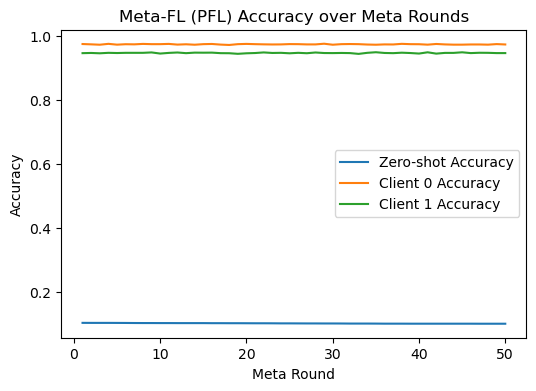

In [109]:
meta_rounds = list(range(1, len(meta_history_mlp['zero_shot_accuracy']) + 1))
zero_shot_acc = meta_history_mlp['zero_shot_accuracy']
client_0_acc = meta_history_mlp['personalized_accuracy'][0]
client_1_acc = meta_history_mlp['personalized_accuracy'][1]

plt.figure(figsize=(6, 4))
plt.plot(meta_rounds, zero_shot_acc, label="Zero-shot Accuracy")
plt.plot(meta_rounds, client_0_acc, label="Client 0 Accuracy")
plt.plot(meta_rounds, client_1_acc, label="Client 1 Accuracy")
plt.xlabel("Meta Round")
plt.ylabel("Accuracy")
plt.title("Meta-FL (PFL) Accuracy over Meta Rounds")
plt.legend()
plt.show()

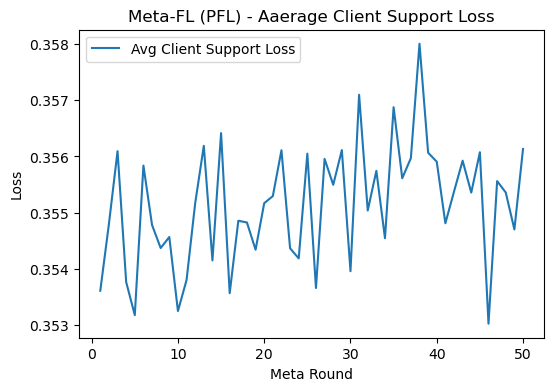

In [110]:
plt.figure(figsize=(6, 4))
plt.plot(meta_rounds, meta_history_mlp['average_client_train_loss'], label='Avg Client Support Loss')
plt.xlabel("Meta Round")
plt.ylabel("Loss")
plt.title("Meta-FL (PFL) - Aaerage Client Support Loss")
plt.legend()
plt.show()


In [ ]:
from copy import deepcopy
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import torch.nn.functional as F
import numpy as np
import torch

def remap_labels(yb, label_map):
    return torch.tensor([label_map[y.item()] for y in yb], dtype=torch.long)

def evaluate_with_label_map(global_model, support_loader, test_loader, label_map, device, inner_epochs, inner_lr):
    model = deepcopy(global_model).to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=inner_lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Remap support labels and adapt
    for _ in range(inner_epochs):
        for xb, yb in support_loader:
            xb = xb.to(device)
            yb = remap_labels(yb, label_map).to(device)
            xb = xb.view(xb.size(0), -1)
            optimizer.zero_grad()
            logits = model(xb)[:, list(label_map.keys())] 
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb_remapped = remap_labels(yb, label_map)
            xb = xb.view(xb.size(0), -1)
            logits = model(xb)[:, list(label_map.keys())]
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(yb_remapped.numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    preds = all_probs.argmax(axis=1)

    print(classification_report(all_labels, preds, digits=4))
    print("Confusion matrix:\n", confusion_matrix(all_labels, preds))
    try:
        print("ROC-AUC (macro OvR):", roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro'))
        print("PR-AUC (macro):", average_precision_score(all_labels, all_probs, average='macro'))
    except ValueError as e:
        print("Warning: Couldn't compute ROC/PR AUC:", e)

In [ ]:
# For client 1 but as 0 index:
client_0_labels = [0, 1, 2, 3, 4]
label_map_0 = {lbl: i for i, lbl in enumerate(client_0_labels)}

# For client 2:
client_1_labels = [5, 6, 7, 8, 9]
label_map_1 = {lbl: i for i, lbl in enumerate(client_1_labels)}

In [ ]:
print("\n=== Per-FedAvg Evaluation for Client 0 ===")
evaluate_with_label_map(
    global_model = trained_meta_model_mlp,
    support_loader = client_support_loaders_10way[0],
    test_loader = client_test_loaders_10way[0],
    label_map = label_map_0,
    device = device,
    inner_epochs = 5,   
    inner_lr = 1e-3     
)

print("\n=== Per-FedAvg Evaluation for Client 1 ===")
evaluate_with_label_map(
    global_model = trained_meta_model_mlp,
    support_loader = client_support_loaders_10way[1],
    test_loader = client_test_loaders_10way[1],
    label_map = label_map_1,
    device = device,
    inner_epochs = 5,
    inner_lr = 1e-3
)


=== Per-FedAvg Evaluation for Client 0 ===
              precision    recall  f1-score   support

           0     0.9251    0.9837    0.9535       980
           1     0.8354    0.9930    0.9074      1135
           2     0.9566    0.7045    0.8114      1032
           3     0.9119    0.9228    0.9173      1010
           4     0.9389    0.9236    0.9312       982

    accuracy                         0.9062      5139
   macro avg     0.9136    0.9055    0.9042      5139
weighted avg     0.9117    0.9062    0.9034      5139

Confusion matrix:
 [[ 964    0    3   11    2]
 [   0 1127    4    4    0]
 [  62  129  727   69   45]
 [   9   33   24  932   12]
 [   7   60    2    6  907]]
ROC-AUC (macro OvR): 0.9916876911217634
PR-AUC (macro): 0.9746432587582177

=== Per-FedAvg Evaluation for Client 1 ===
              precision    recall  f1-score   support

           0     0.9810    0.1155    0.2066       892
           1     0.7815    0.9781    0.8688       958
           2     0.8676  

### MOCHA (10-Class CNN Task)

In [ ]:
NUM_CLASSES_MNIST = 10
MNIST_DATA_PATH = "./mnist_data/"
if not os.path.exists(MNIST_DATA_PATH):
    os.makedirs(MNIST_DATA_PATH)

CLIENT_DIGITS_MAP_10_CLASS = {
    0: list(range(5)),   
    1: list(range(5, 10))  
}

# 1) transforms (normalize + to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2) load full train/test sets
mnist_train = datasets.MNIST(root=MNIST_DATA_PATH,
                             train=True,
                             download=True,
                             transform=transform)
mnist_test  = datasets.MNIST(root=MNIST_DATA_PATH,
                             train=False,
                             download=True,
                             transform=transform)

# 3) compute indices for client 0 and client 1
train_idxs = {
    cid: [i for i, (_, lbl) in enumerate(mnist_train) if lbl in CLIENT_DIGITS_MAP_10_CLASS[cid]]
    for cid in [0, 1]
}
test_idxs = {
    cid: [i for i, (_, lbl) in enumerate(mnist_test) if lbl in CLIENT_DIGITS_MAP_10_CLASS[cid]]
    for cid in [0, 1]
}

# 4) create Subsets and DataLoaders
batch_size_train = 64
batch_size_test  = 128

client_train_loaders_10way = {}
client_test_loaders_10way = {}

for cid in [0, 1]:
    subset_train = Subset(mnist_train, train_idxs[cid])
    subset_test  = Subset(mnist_test,  test_idxs[cid])

    client_train_loaders_10way[cid] = DataLoader(
        subset_train,
        batch_size=batch_size_train,
        shuffle=True,
        num_workers=0
    )
    client_test_loaders_10way[cid] = DataLoader(
        subset_test,
        batch_size=batch_size_test,
        shuffle=False,
        num_workers=0
    )

    train_labels = [lbl for (_, lbl) in subset_train]
    test_labels  = [lbl for (_, lbl) in subset_test]
    print(f"Client {cid} train digit counts: {np.bincount(train_labels, minlength=10)}")
    print(f"Client {cid} test  digit counts: {np.bincount(test_labels,  minlength=10)}\n")

Client 0 train digit counts: [5923 6742 5958 6131 5842    0    0    0    0    0]
Client 0 test  digit counts: [ 980 1135 1032 1010  982    0    0    0    0    0]

Client 1 train digit counts: [   0    0    0    0    0 5421 5918 6265 5851 5949]
Client 1 test  digit counts: [   0    0    0    0    0  892  958 1028  974 1009]



In [33]:
clients_cnn_task = [0, 1]
client_train_loaders_cnn_mnist = [
    client_train_loaders_10way[0],
    client_train_loaders_10way[1]
]
client_test_loaders_cnn_mnist = [
    client_test_loaders_10way[0],
    client_test_loaders_10way[1]
]

In [ ]:
CNN_HEAD_FC_HIDDEN_HP    = 64    
MOCHA_NUM_ROUNDS         = 50     
MOCHA_LOCAL_EPOCHS       = 5   
MOCHA_LR                 = 1e-3   # local learning rate
MOCHA_WEIGHT_DECAY_LOCAL = 1e-4   # local weight decay
MOCHA_MAX_GRAD_NORM_LOCAL= 1.0    # gradient clipping norm

In [ ]:
print("\n" + "="*40 + "\nMOCHA Execution: 10-Class MNIST with CNN\n" + "="*40)

cnn_backbone_factory = lambda: CNN_Backbone(input_channels=1)

global_mocha_bckbn_cnn, mocha_client_hds_cnn, mocha_hist_cnn = multitask_federated_averaging_cnn(
    cnn_backbone_factory_fn = cnn_backbone_factory,
    cnn_head_factory_fn     = CNN_Head,                
    train_loaders           = client_train_loaders_cnn_mnist,
    test_loaders            = client_test_loaders_cnn_mnist,
    client_ids_list         = clients_cnn_task,
    num_classes             = NUM_CLASSES_MNIST,        
    head_fc_hidden_hp       = CNN_HEAD_FC_HIDDEN_HP,    
    num_rounds              = MOCHA_NUM_ROUNDS,         
    local_epochs            = MOCHA_LOCAL_EPOCHS,       
    lr                      = MOCHA_LR,                 
    weight_decay_local      = MOCHA_WEIGHT_DECAY_LOCAL, 
    max_grad_norm_local     = MOCHA_MAX_GRAD_NORM_LOCAL,
    device                  = device
) # Ran for 10 m and 44.6 s


MOCHA Execution: 10-Class MNIST with CNN

>>> MNIST CNN MOCHA Round 1/50
  [Client 0] Inner-train loss: 0.0533
  [Client 1] Inner-train loss: 0.0805
  [Client 0] Test Loss: 0.0158, Acc: 0.9957, BalAcc: 0.9957, Prec: 0.9959, Rec: 0.9957, F1: 0.9958, ROC-AUC: nan, PR-AUC: 0.4999
  [Client 1] Test Loss: 0.0579, Acc: 0.9817, BalAcc: 0.9818, Prec: 0.9819, Rec: 0.9818, F1: 0.9817, ROC-AUC: nan, PR-AUC: 0.4996

>>> MNIST CNN MOCHA Round 2/50
  [Client 0] Inner-train loss: 0.0143
  [Client 1] Inner-train loss: 0.0261
  [Client 0] Test Loss: 0.0060, Acc: 0.9977, BalAcc: 0.9976, Prec: 0.9977, Rec: 0.9976, F1: 0.9977, ROC-AUC: nan, PR-AUC: 0.5000
  [Client 1] Test Loss: 0.0377, Acc: 0.9887, BalAcc: 0.9887, Prec: 0.9887, Rec: 0.9887, F1: 0.9887, ROC-AUC: nan, PR-AUC: 0.4996

>>> MNIST CNN MOCHA Round 3/50
  [Client 0] Inner-train loss: 0.0091
  [Client 1] Inner-train loss: 0.0178
  [Client 0] Test Loss: 0.0048, Acc: 0.9979, BalAcc: 0.9978, Prec: 0.9979, Rec: 0.9978, F1: 0.9978, ROC-AUC: nan, PR-A

In [83]:
def evaluate_mocha_client(
    global_backbone, client_head,
    support_loader, test_loader,
    label_map, device,
    inner_epochs=1, inner_lr=1e-3
):
    model = CNNMultitaskModel(
        deepcopy(global_backbone), deepcopy(client_head)
    ).to(device)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=inner_lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    for _ in range(inner_epochs):
        for xb, yb in support_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)

            logits = logits[:, list(label_map.keys())]  # Select relevant outputs only
            probs = F.softmax(logits, dim=1).cpu().numpy()
            yb_remapped = torch.tensor([label_map[y.item()] for y in yb], dtype=torch.long)

            all_probs.append(probs)
            all_labels.append(yb_remapped.numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    preds = all_probs.argmax(axis=1)

    # Pretty report
    original_labels = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]
    print(classification_report(
        all_labels, preds, digits=4,
        target_names=[str(d) for d in original_labels]
    ))
    print("Confusion matrix:\n", confusion_matrix(all_labels, preds))

    try:
        print("ROC-AUC (macro OvR):", roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro'))
        print("PR-AUC (macro):", average_precision_score(all_labels, all_probs, average='macro'))
    except ValueError as e:
        print("Warning: Couldn't compute ROC/PR AUC:", e)


In [84]:
# Assume same label maps as before:
label_map_0 = {lbl: i for i, lbl in enumerate([0, 1, 2, 3, 4])}
label_map_1 = {lbl: i for i, lbl in enumerate([5, 6, 7, 8, 9])}

print("\n=== MOCHA Personalized Evaluation for Client 0 ===")
evaluate_mocha_client(
    global_backbone = global_mocha_bckbn_cnn,
    client_head     = mocha_client_hds_cnn[0],
    support_loader  = client_train_loaders_cnn_mnist[0],
    test_loader     = client_test_loaders_cnn_mnist[0],
    label_map       = label_map_0,
    device          = device,
    inner_epochs    = 5,
    inner_lr        = 1e-3
)

print("\n=== MOCHA Personalized Evaluation for Client 1 ===")
evaluate_mocha_client(
    global_backbone = global_mocha_bckbn_cnn,
    client_head     = mocha_client_hds_cnn[1],  
    support_loader  = client_train_loaders_cnn_mnist[1],
    test_loader     = client_test_loaders_cnn_mnist[1],
    label_map       = label_map_1,
    device          = device,
    inner_epochs    = 5,
    inner_lr        = 1e-3
)


=== MOCHA Personalized Evaluation for Client 0 ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       980
           1     0.9991    0.9991    0.9991      1135
           2     0.9961    1.0000    0.9981      1032
           3     0.9990    0.9970    0.9980      1010
           4     1.0000    0.9980    0.9990       982

    accuracy                         0.9988      5139
   macro avg     0.9989    0.9988    0.9988      5139
weighted avg     0.9988    0.9988    0.9988      5139

Confusion matrix:
 [[ 980    0    0    0    0]
 [   0 1134    0    1    0]
 [   0    0 1032    0    0]
 [   0    0    3 1007    0]
 [   0    1    1    0  980]]
ROC-AUC (macro OvR): 0.9999991106610395
PR-AUC (macro): 0.9999965017579667

=== MOCHA Personalized Evaluation for Client 1 ===
              precision    recall  f1-score   support

           5     0.9944    0.9978    0.9961       892
           6     0.9990    0.9979    0.9984       958
         

## **Plotting Histories**

### Plotting MOCHA.


--- Plotting MOCHA CNN: Per-Client Test Loss and Accuracy ---


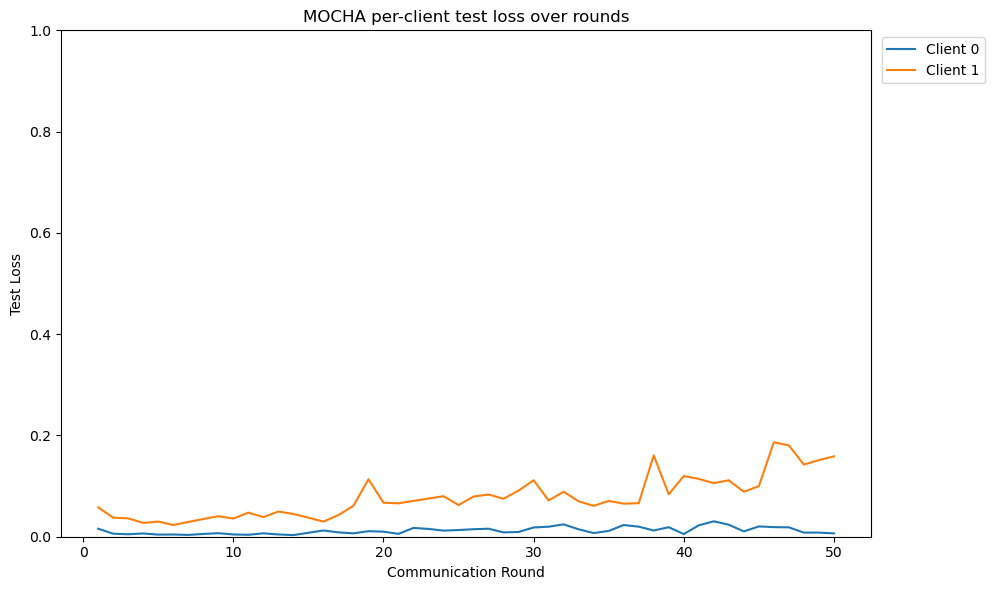

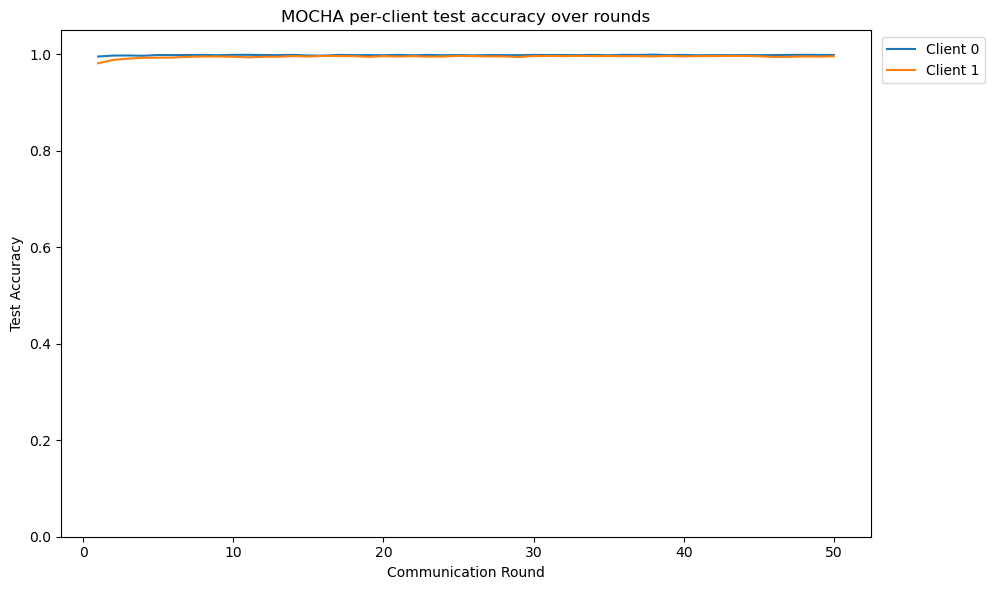

In [ ]:
import matplotlib.pyplot as plt

if 'mocha_hist_cnn' in locals() and mocha_hist_cnn.get('per_client_test_loss'):
    print("\n--- Plotting MOCHA CNN: Per-Client Test Loss and Accuracy ---")

    num_rounds = len(mocha_hist_cnn['average_client_test_loss'])
    rounds_range = range(1, num_rounds + 1)
    num_clients = len(mocha_hist_cnn['per_client_test_loss'])

    # Plot 1: Per-Client Test Loss
    plt.figure(figsize=(10, 6), facecolor='white')
    for i in range(num_clients):
        plt.plot(rounds_range, mocha_hist_cnn['per_client_test_loss'][i], label=f'Client {i}')
    plt.title('MOCHA per-client test loss over rounds')
    plt.xlabel('Communication Round')
    plt.ylabel('Test Loss')
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))
    plt.tight_layout()
    plt.show()

    # Plot 2: Per-Client Test Accuracy
    plt.figure(figsize=(10, 6), facecolor='white')
    for i in range(num_clients):
        plt.plot(rounds_range, mocha_hist_cnn['per_client_accuracy'][i], label=f'Client {i}')
    plt.title('MOCHA per-client test accuracy over rounds')
    plt.xlabel('Communication Round')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))
    plt.tight_layout()
    plt.show()

else:
    print("MOCHA CNN history not available for plotting or 'per_client_test_loss' is missing.")